# Relationship between Critical Temperature and other features

In [77]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from utils.Combinations import Step, Pipe, extract_combinations, Combination
from utils.Search import grid_search, print_results, best_hyperparameters

from utils.Custom_Steps import HighCorrFeaturesRemover, OnlyFormula, OnlyProperties
from sklearn.pipeline import Pipeline

In [78]:
plt.style.use("seaborn-v0_8")

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "outputs/"

RANDOM_STATE = 42

---
---
## Data Load

In [79]:
df = pd.concat(
    [
        pd.read_csv(DATA_FOLDER + "formula_train.csv").drop(columns=["critical_temp"]),
        pd.read_csv(DATA_FOLDER + "train.csv"),
    ],
    axis=1,
)
print("Shapes of Properties+Formula df: ", df.shape)

Shapes of Properties+Formula df:  (17010, 169)


In [80]:
# Remove "material" feature
df = df.drop(columns="material")

---
---
## Split

In [81]:
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

X_train = train.drop(columns=["critical_temp"])
y_train = train[["critical_temp"]]

X_test = test.drop(columns=["critical_temp"])
y_test = test[["critical_temp"]]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13608, 167), (3402, 167), (13608, 1), (3402, 1))

---
## Linear Regression

In [82]:
estimator_tag = "linear_regression"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "minmax + linear_regression",
            Pipeline([("minmax", preprocessing.MinMaxScaler()), ("linear_regression", LinearRegression())]),
            {},
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

features_coefs_lr = [
    (feature, coef) for feature, coef in zip(model.named_steps["minmax"].get_feature_names_out(), model[-1].coef_)
]
features_coefs_lr.sort(key=lambda x: abs(x[1]), reverse=True)
for feature, coef in features_coefs_lr:
    print(f"{feature}: {coef}")


Combination 1/1  |  minmax + linear_regression
  ==> R2: 0.7538253028800117	MSE: 280.10712800562004
wtd_mean_atomic_radius: 419.08747697026047
wtd_gmean_atomic_radius: -370.195516708526
wtd_mean_atomic_mass: -257.6455502743736
wtd_mean_ThermalConductivity: 203.71039708392595
mean_fie: -201.54514675128493
Ba: 197.1231544668303
mean_atomic_mass: 195.53723106874173
wtd_mean_FusionHeat: -193.03511021978102
std_ElectronAffinity: 173.01747192890525
gmean_fie: 168.428656452811
Si: -157.6995727823293
entropy_Valence: 154.952169400295
wtd_gmean_atomic_mass: 150.19963509782986
wtd_entropy_Valence: -148.30982131200093
wtd_gmean_FusionHeat: 145.77515726777105
wtd_gmean_ElectronAffinity: -141.8413948781697
wtd_gmean_ThermalConductivity: -134.01129874019452
mean_FusionHeat: 132.7799911228304
mean_Density: -129.71772929728252
wtd_entropy_fie: 124.63048377924989
wtd_mean_ElectronAffinity: 114.23506747358388
range_ElectronAffinity: -111.7167240551212
mean_atomic_radius: -107.53743112158008
wtd_mean_De

---
## Random Forest


In [83]:
estimator_tag = "random_forest"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "high_corr_features_remover + lmax + minmax + random_forest",
            Pipeline(
                [
                    ("high_corr_features_remover", HighCorrFeaturesRemover()),
                    ("lmax", preprocessing.Normalizer(norm="max")),
                    ("minmax", preprocessing.MinMaxScaler()),
                    ("random_forest", RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "random_forest__max_samples": [0.66],
                "random_forest__criterion": ["squared_error"],
                "random_forest__n_estimators": [200],
                "random_forest__max_depth": [25],
                "random_forest__max_features": [0.6],
                "high_corr_features_remover__corr_threshold": [0.99],
                "random_forest__ccp_alpha": [0],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

features_importances_rf = [
    (feature, coef)
    for feature, coef in zip(model.named_steps["lmax"].feature_names_in_, model[-1].feature_importances_)
]
features_importances_rf.sort(key=lambda x: abs(x[1]), reverse=True)
for feature, importance in features_importances_rf:
    print(f"{feature}: {importance}")


Combination 1/1  |  high_corr_features_remover + lmax + minmax + random_forest
  ==> R2: 0.927733879477879	MSE: 82.2271976298726
Cu: 0.4012839763069473
wtd_mean_Valence: 0.1374349988039968
O: 0.06814013224848871
Ca: 0.040589299009785425
wtd_std_Valence: 0.031467226988656775
gmean_Density: 0.0288483731352679
range_ThermalConductivity: 0.02622368172272774
Ba: 0.015597894396040068
wtd_std_ThermalConductivity: 0.0102388429997815
wtd_entropy_Density: 0.00971936894845027
mean_Valence: 0.007617717228368103
wtd_gmean_ElectronAffinity: 0.007551107599563978
wtd_range_atomic_mass: 0.006686748323335573
wtd_mean_ThermalConductivity: 0.006293487659357053
wtd_std_Density: 0.005706462480263427
Zn: 0.0055372734598585095
std_atomic_mass: 0.005364639805425856
wtd_gmean_Density: 0.005243356500105462
wtd_gmean_ThermalConductivity: 0.005189668617531372
wtd_entropy_atomic_mass: 0.005151458989725994
wtd_range_Valence: 0.005070897312813719
Fe: 0.004917874520453755
range_fie: 0.0045847727474797395
wtd_entropy_

---
## XGBoost


In [87]:
estimator_tag = "xg_boost"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "xg_boost",
            Pipeline(
                [
                    ("xg_boost", XGBRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "xg_boost__n_estimators": [450],
                "xg_boost__learning_rate": [0.15],
                "xg_boost__max_depth": [6],
                "xg_boost__min_child_weight": [3],
                "xg_boost__gamma": [0.5],
                "xg_boost__subsample": [1.0],
                "xg_boost__colsample_bytree": [1.0],
                "xg_boost__reg_lambda": [1.0],
                "xg_boost__reg_alpha": [0.1],
                "xg_boost__tree_method": ["auto"],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

features_importances_xgb = [
    (feature, coef) for feature, coef in zip(model[-1].get_booster().feature_names, model[-1].feature_importances_)
]
features_importances_xgb.sort(key=lambda x: abs(x[1]), reverse=True)
for feature, importance in features_importances_xgb:
    print(f"{feature}: {importance}")


Combination 1/1  |  xg_boost
  ==> R2: 0.927331058241855	MSE: 82.68554327157501
range_ThermalConductivity: 0.769223153591156
wtd_gmean_ThermalConductivity: 0.038619399070739746
Ca: 0.015694621950387955
range_atomic_radius: 0.01533922366797924
Ba: 0.013364405371248722
wtd_gmean_Valence: 0.008045708760619164
Fe: 0.007661336567252874
Zn: 0.0075575136579573154
wtd_std_ElectronAffinity: 0.006659858860075474
std_Density: 0.0058203935623168945
Mg: 0.0051477220840752125
Pr: 0.0038726981729269028
Sr: 0.003817981341853738
wtd_std_Valence: 0.003458464751020074
gmean_ElectronAffinity: 0.0032610350754112005
wtd_mean_Valence: 0.0032251400407403708
wtd_range_Valence: 0.0025499816983938217
std_atomic_mass: 0.002521906280890107
gmean_Density: 0.00232929945923388
Nb: 0.0020400742068886757
wtd_mean_ThermalConductivity: 0.001954298233613372
gmean_atomic_mass: 0.0017682944890111685
gmean_ThermalConductivity: 0.0017458816291764379
std_ThermalConductivity: 0.0016670876648277044
Co: 0.0016193012706935406
wtd

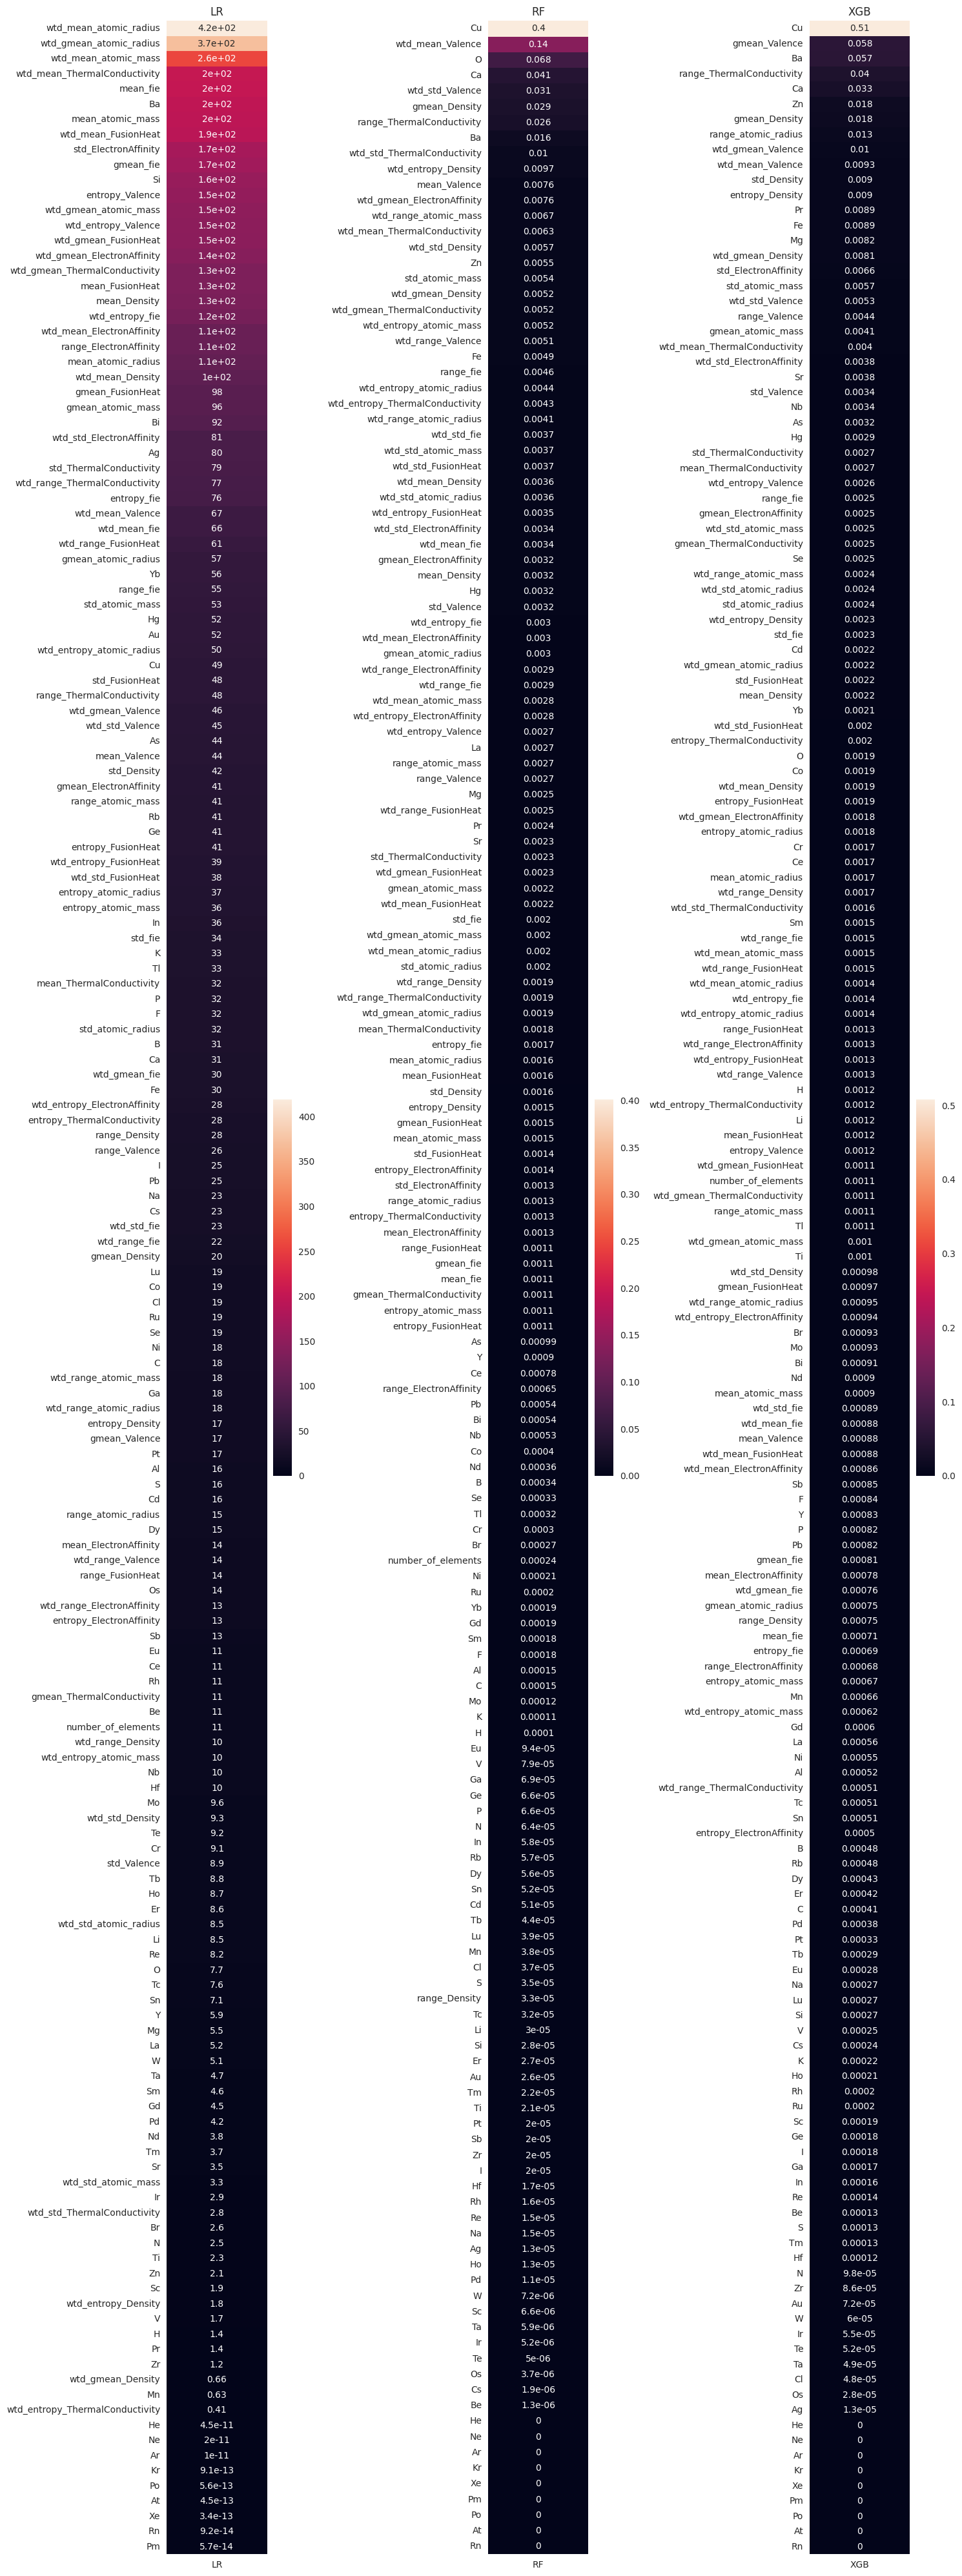

In [86]:
fig = plt.figure(figsize=(15, 40))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0])
df = pd.DataFrame(index=[x[0] for x in features_coefs_lr])
df["LR"] = [abs(x[1]) for x in features_coefs_lr]
sns.heatmap(df[["LR"]], annot=True, ax=ax)
ax.set_title("LR")

ax = plt.subplot(gs[1])
df = pd.DataFrame(index=[x[0] for x in features_importances_rf])
df["RF"] = [abs(x[1]) for x in features_importances_rf]
sns.heatmap(df[["RF"]], annot=True, ax=ax)
ax.set_title("RF")

ax = plt.subplot(gs[2])
df = pd.DataFrame(index=[x[0] for x in features_importances_xgb])
df["XGB"] = [abs(x[1]) for x in features_importances_xgb]
sns.heatmap(df[["XGB"]], annot=True, ax=ax)
ax.set_title("XGB")

plt.tight_layout()
plt.show()